In [1]:
import numpy as np
import pandas as pd

import os

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
### merge overlap gene sets
dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
all_sets = os.listdir('../results/genesets/overlap/csvs/')
for rtype in ['filtered', 'random_uniform_0', 'random_dist_0']:
    for dname1 in dnames:
        for dname2 in dnames:
            if dname1 != dname2:
                name = dname1 + '_' + rtype + '_minus_' + dname2 + '_' + rtype
                results = pd.read_csv('../results/genesets/overlap/csvs/%s_0.csv' % name,
                                     sep=',', header=0, index_col=0)
                i = 1
                while True:
                    if (name + '_' + str(i)+'.csv') in all_sets:
                        data = pd.read_csv('../results/genesets/overlap/csvs/%s_%i.csv' % (name, i),
                                           sep=',', header=0, index_col=0)
                        results = pd.concat([results, data])
                        results.index = range(len(results))
                        i += 1
                    else:
                        break
                results.to_csv('../results/genesets/overlap/merged/%s.csv' % name)

In [3]:
def plot_set_difference(bname='progeny', atype='_abs'):
    dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
    scores={}
    sizes = {}
    for dname1 in dnames:
        scores[dname1]=[]
        sizes[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname1,'_filtered',dname2,'_filtered',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size_1minus2 = pd.read_csv('../results/genesets/overlap/merged/%s%s_minus_%s%s.csv' % (dname1,'_filtered',dname2,'_filtered'),
                                      sep=',', header=0, index_col=0)['Set'].value_counts()
            size_1minus2 = size_1minus2[score_1minus2.index]
            scores[dname1]+=list(score_1minus2.values)
            sizes[dname1]+=list(size_1minus2.values)
    scores_df=pd.DataFrame(columns=['Data','Delta','Size'])
    for dname in scores:
        temp=pd.DataFrame(columns=scores_df.columns)
        temp['Delta']=scores[dname]
        temp['Data']=dname
        temp['Size']=sizes[dname]
        scores_df=pd.concat([scores_df,temp])
    scores_df['Random']='Actual gene set'
    scores_random={}
    sizes_random = {}
    for dname1 in dnames:
        scores_random[dname1]=[]
        sizes_random[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname1,'_random_dist_0',dname2,'_random_dist_0',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size_1minus2 = pd.read_csv('../results/genesets/overlap/merged/%s%s_minus_%s%s.csv' % (dname1,'_random_dist_0',dname2,'_random_dist_0'),
                                      sep=',', header=0, index_col=0)['Set'].value_counts()
            size_1minus2 = size_1minus2[score_1minus2.index]
            scores_random[dname1]+=list(score_1minus2.values)
            sizes_random[dname1] += list(size_1minus2.values)
    scores_random_df=pd.DataFrame(columns=['Data','Delta','Size'])
    for dname in scores_random:
        temp=pd.DataFrame(columns=scores_random_df.columns)
        temp['Delta']=scores_random[dname]
        temp['Data']=dname
        temp['Size']=sizes_random[dname]
        scores_random_df=pd.concat([scores_random_df,temp])
    scores_random_df['Random']='Random gene set'

    scores=pd.concat([scores_df, scores_random_df])
    scores.columns=['Data', 'Delta', 'Size','Gene set']
    scores = scores.sort_values(['Data','Gene set'])
    plt.figure(figsize=(4,4), dpi=300)
    sns.set_palette('GnBu',2)
    sns.boxplot(scores['Data'],scores['Delta'], hue=scores['Gene set'])
    plt.xlabel('Original gene set database', size=15)
    plt.xticks(range(6),['High confidence\nDoRothEA', 'Low confidence\nDoRothEA', 'Biocarta',
                        'CGP', 'KEGG' ,'REACTOME'],rotation=45)
    plt.ylabel('Informative score of\nset difference gene sets', size=15)
    plt.tight_layout()
    plt.legend(loc=2, title='Gene set')
    return scores

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


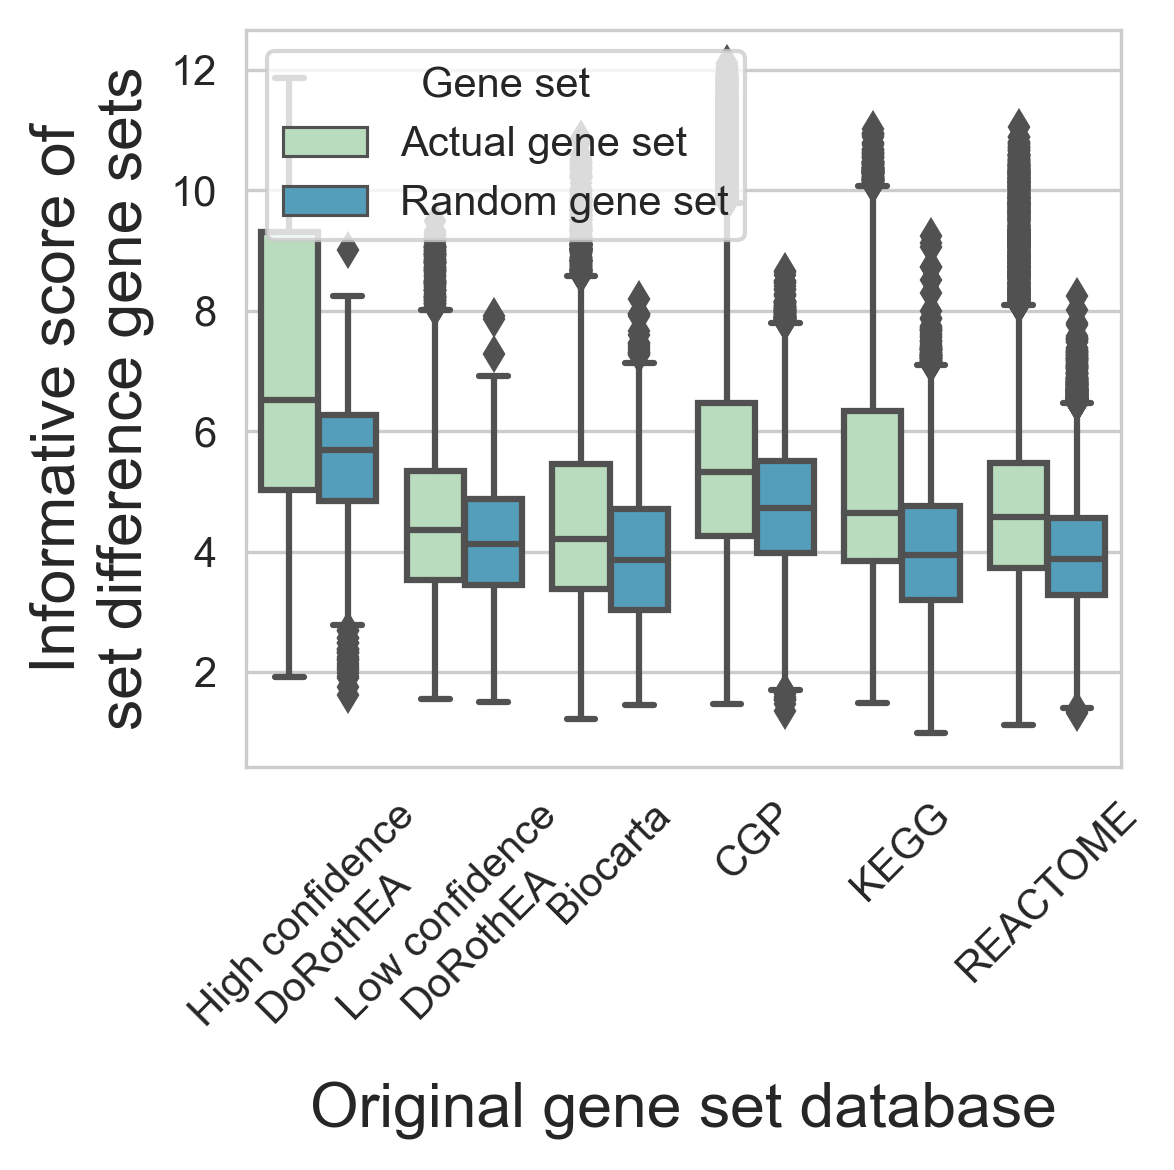

In [4]:
scores = plot_set_difference(bname='progeny', atype='_abs')
plt.savefig('../figures/raw/Fig5B.pdf')
scores.index = range(len(scores.index))
scores.to_csv('../results/benchmark/progeny_abs_overlap.csv')

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


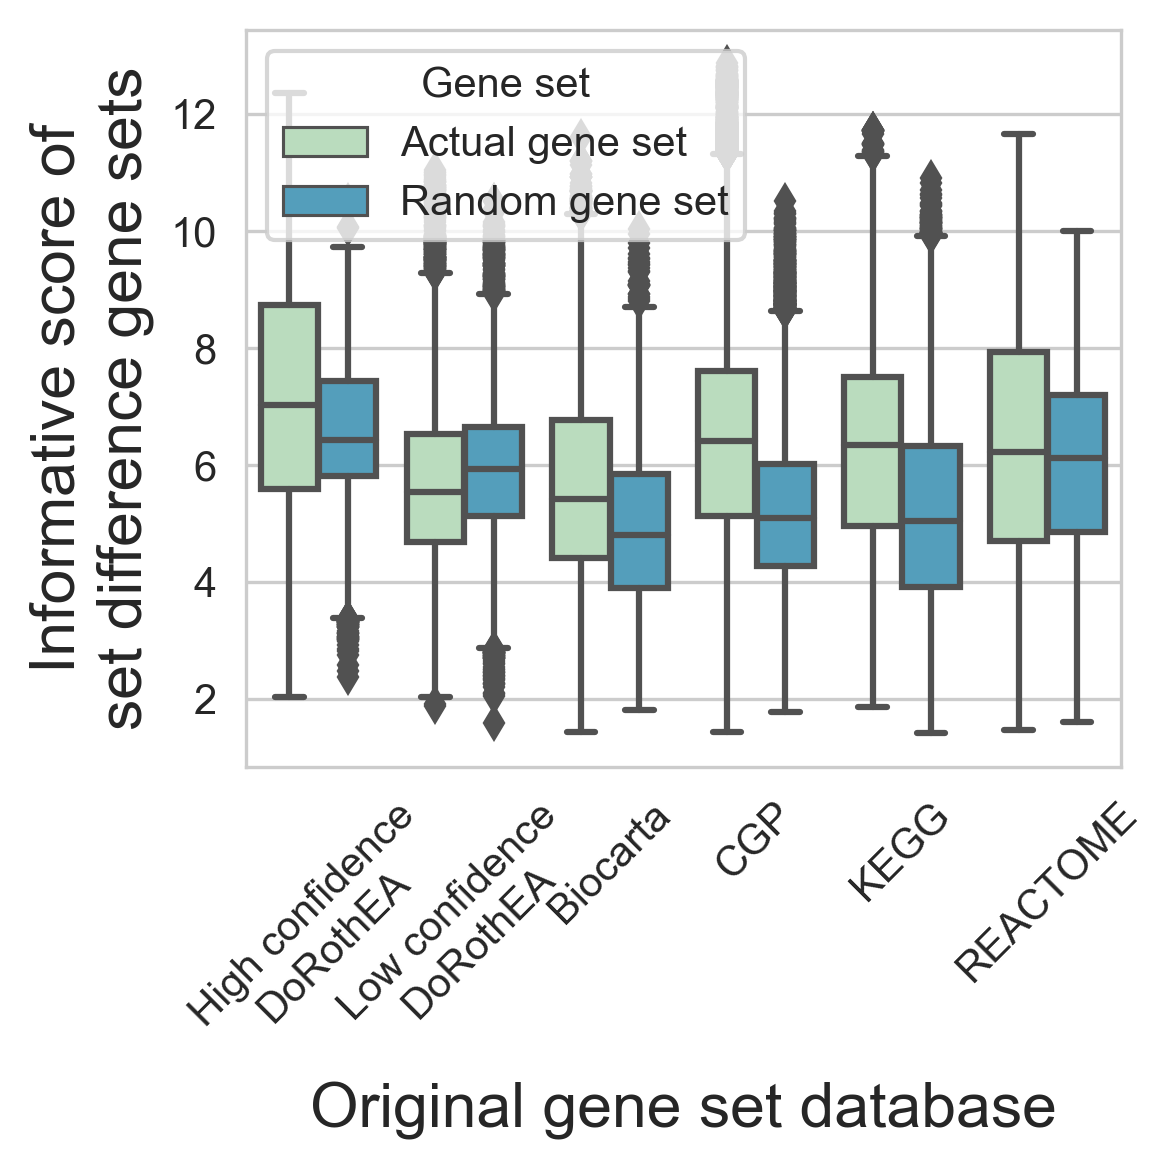

In [6]:
scores = plot_set_difference(bname='progeny', atype='')
plt.savefig('../figures/raw/SFig7A.pdf')
scores.index = range(len(scores.index))
scores.to_csv('../results/benchmark/progeny_overlap.csv')

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


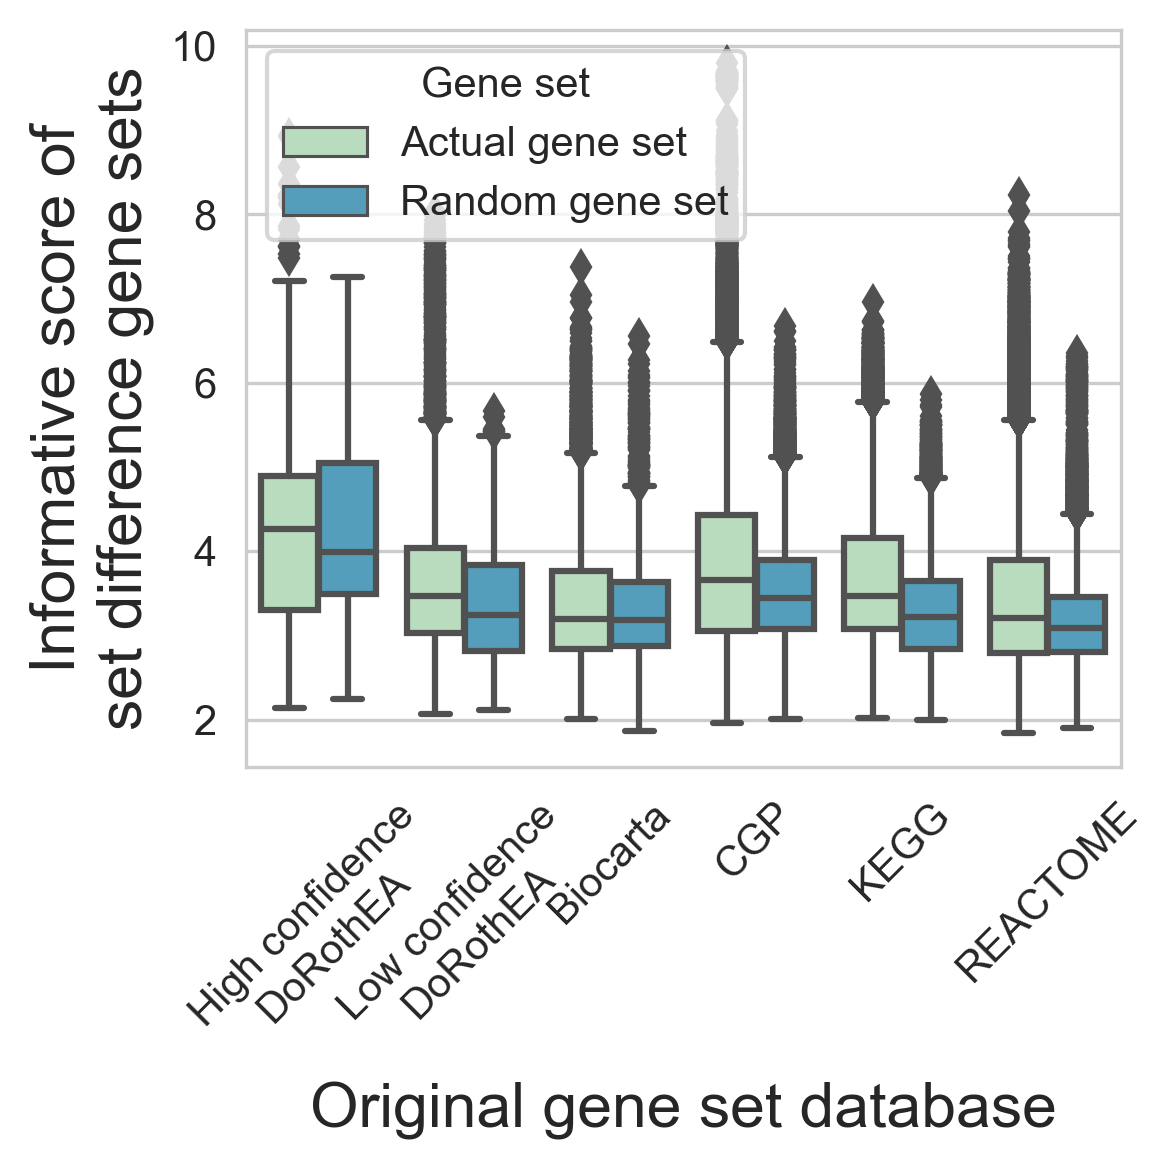

In [7]:
scores = plot_set_difference(bname='gdsc', atype='_abs')
plt.savefig('../figures/raw/SFig7B.pdf')
scores.index = range(len(scores.index))
scores.to_csv('../results/benchmark/gdsc_abs_overlap.csv')

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


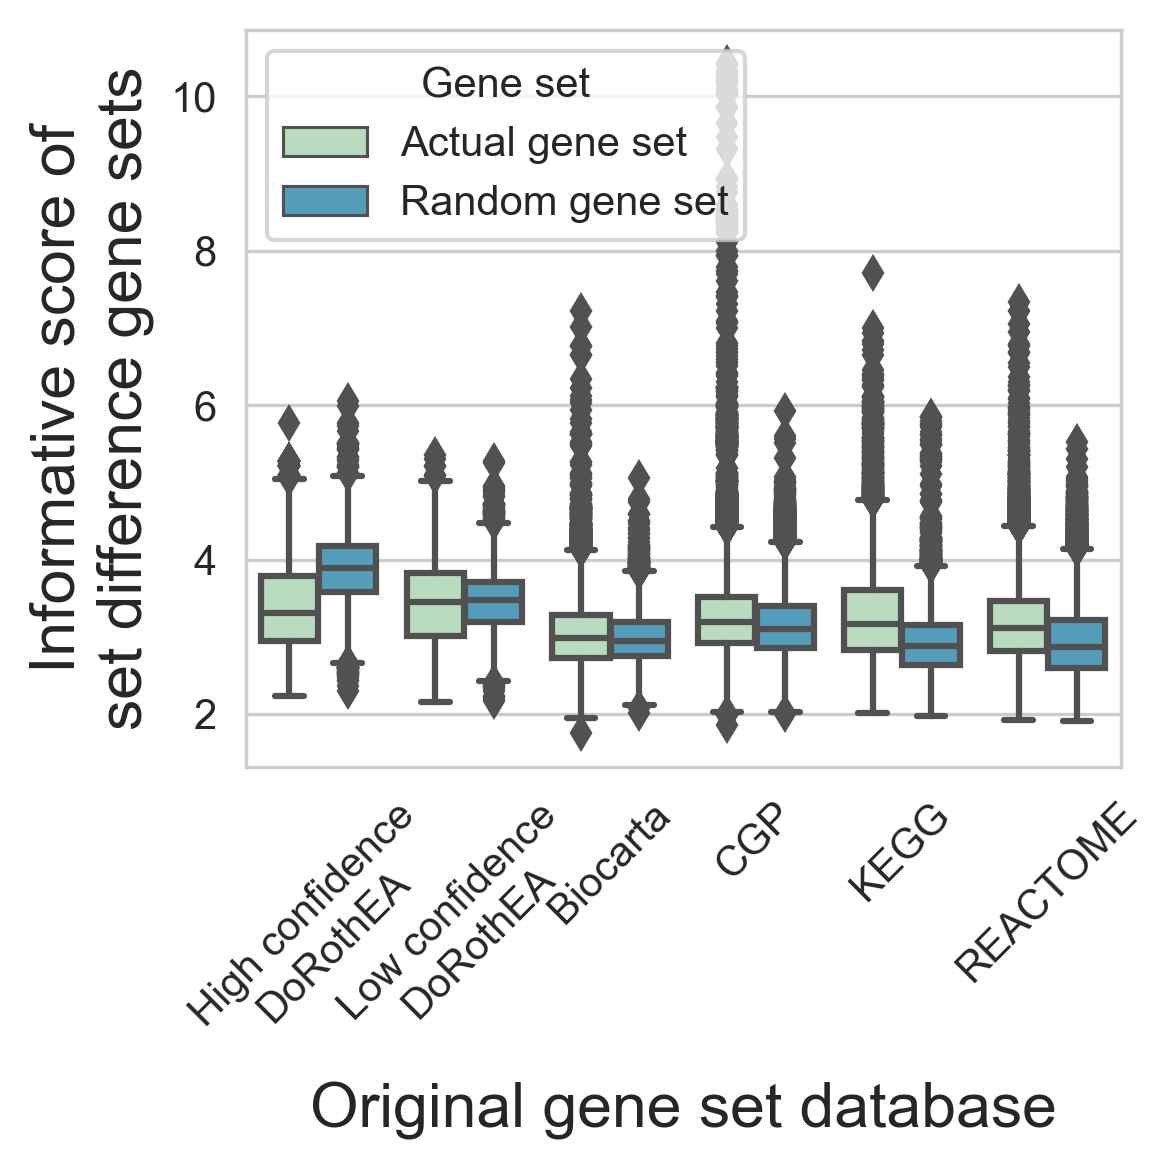

In [8]:
scores = plot_set_difference(bname='gdsc', atype='')
plt.savefig('../figures/raw/SFig7C.pdf')
scores.index = range(len(scores.index))
scores.to_csv('../results/benchmark/gdsc_overlap.csv')

In [2]:
from subprocess import call

In [10]:
call(['Rscript','../code/overlap_statistics.R'])

0

In [11]:
results = pd.read_csv('../results/benchmark/overlap_stats.csv', sep=',', header=0, index_col=0)

In [12]:
results.head()

,anova_d,anova_r,anova_s,pcd,pbio,pcgp,pkegg,preac,cd,bio,cgp,kegg,reac
progeny_abs_overlap,0,0,0.000000e+00,0.000000e+00,0,0,0,0,-2.2700,-2.100,-1.390,-1.760,-2.130
progeny_overlap,0,0,0.000000e+00,0.000000e+00,0,0,0,0,-1.3500,-1.200,-0.835,-0.759,-0.851
gdsc_abs_overlap,0,0,6.980000e-74,0.000000e+00,0,0,0,0,-0.4520,-0.695,-0.327,-0.438,-0.702
gdsc_overlap,0,0,5.400000e-74,1.450000e-13,0,0,0,0,0.0679,-0.301,-0.142,-0.136,-0.211


In [13]:
def infromative_score_decrease(bname='progeny', atype='_abs'):
    dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
    delta={}
    sizes = {}
    for dname1 in dnames:
        delta[dname1]=[]
        sizes[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,'_filtered',atype),
                          sep=',',header=0,index_col=0).abs().max(1)
            score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname2,'_filtered',dname1,'_filtered',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size = pd.read_csv('../results/genesets/single/csvs/%s_filtered.csv' % dname1,
                              sep=',', header=0, index_col=0)['Set'].value_counts()
            if dname2<dname1:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
                size=size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
            else:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
                size = size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
            delta[dname1]+=list(score_2minus1.values-score.values)
            sizes[dname1]+=list(size.values)
    delta_df=pd.DataFrame(columns=['Data','Delta', 'Size'])
    for dname in delta:
        temp=pd.DataFrame(columns=delta_df.columns)
        temp['Delta']=delta[dname]
        temp['Data']=dname
        temp['Size']=sizes[dname]
        delta_df=pd.concat([delta_df,temp])
    delta_df['Random']='Actual gene set'    
    delta_random={}
    sizes_random={}
    for dname1 in dnames:
        delta_random[dname1]=[]
        sizes_random[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,'_random_dist_0',atype),
                          sep=',',header=0,index_col=0).abs().max(1)
            score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname2,'_random_dist_0',dname1,'_random_dist_0',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size = pd.read_csv('../results/genesets/single/csvs/%s_random_dist_0.csv' % dname1,
                              sep=',', header=0, index_col=0)['Set'].value_counts()
            if dname2<dname1:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
                size=size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
            else:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
                size = size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
            delta_random[dname1]+=list(score_2minus1.values-score.values)
            sizes_random[dname1]+=list(size.values)
    delta_random_df=pd.DataFrame(columns=['Data','Delta', 'Size'])
    for dname in delta_random:
        temp=pd.DataFrame(columns=delta_random_df.columns)
        temp['Delta']=delta_random[dname]
        temp['Data']=dname
        temp['Size']=sizes_random[dname]
        delta_random_df=pd.concat([delta_random_df,temp])
    delta_random_df['Random']='Random gene set'
    delta = pd.concat([delta_df,delta_random_df])
    delta.columns = ['Data', 'Delta', 'Size','Gene set']
    delta = delta.sort_values(['Data', 'Gene set'])
    plt.figure(figsize=(4,4), dpi=300)
    sns.set_palette('GnBu',2)
    sns.barplot(delta['Data'],delta['Delta'], hue=delta['Gene set'])
    plt.xlabel('Removed gene set database', size=15)
    plt.xticks(range(6),['High confidence\nDoRothEA', 'Low confidence\nDoRothEA', 'Biocarta',
                            'CGP', 'KEGG' ,'REACTOME'],rotation=45)
    plt.ylabel('Informative score decrease', size=15)
    plt.tight_layout()
    plt.legend(loc=0, title='Gene set')
    return delta

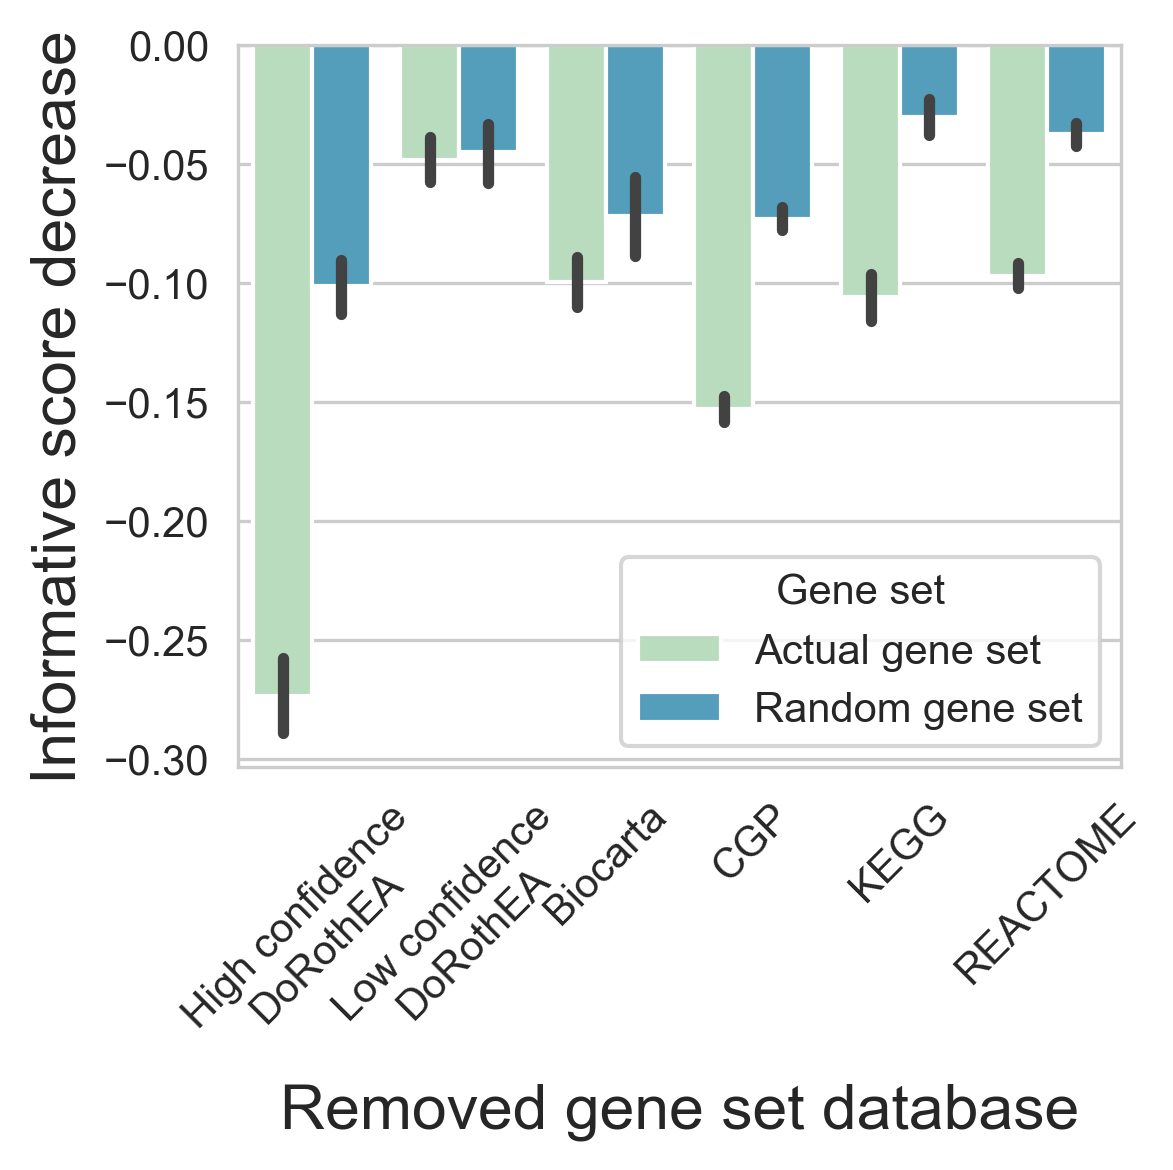

In [14]:
delta = infromative_score_decrease(bname='progeny', atype='_abs')
delta.index = range(len(delta.index))
plt.savefig('../figures/raw/Fig5C.pdf')
delta.to_csv('../results/benchmark/progeny_abs_remove.csv')

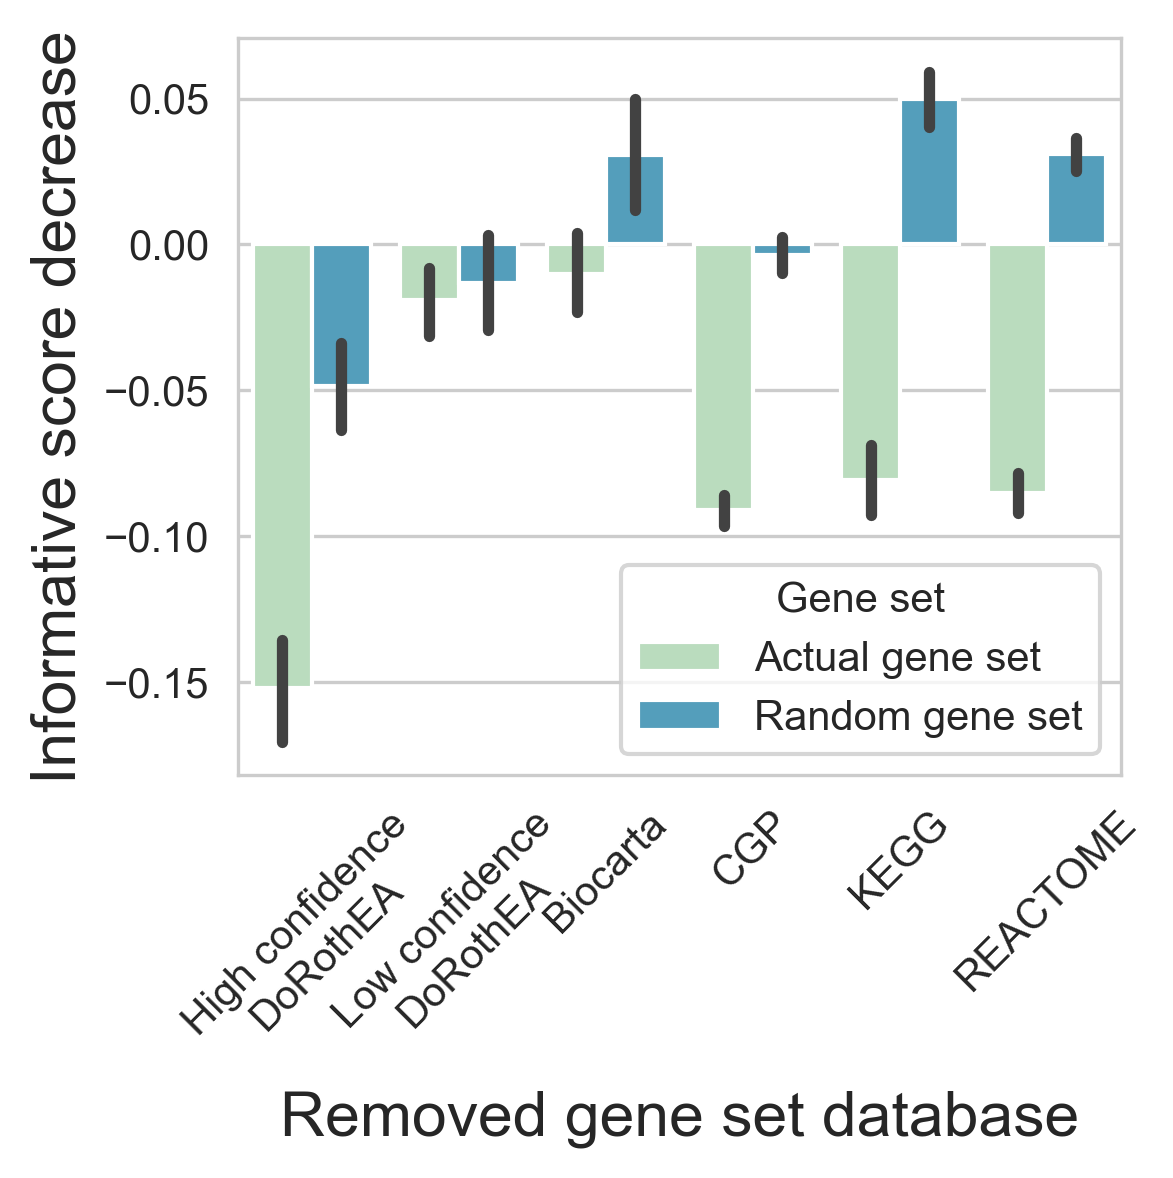

In [15]:
delta = infromative_score_decrease(bname='progeny', atype='')
delta.index = range(len(delta.index))
plt.savefig('../figures/raw/SFig7D.pdf')
delta.to_csv('../results/benchmark/progeny_remove.csv')

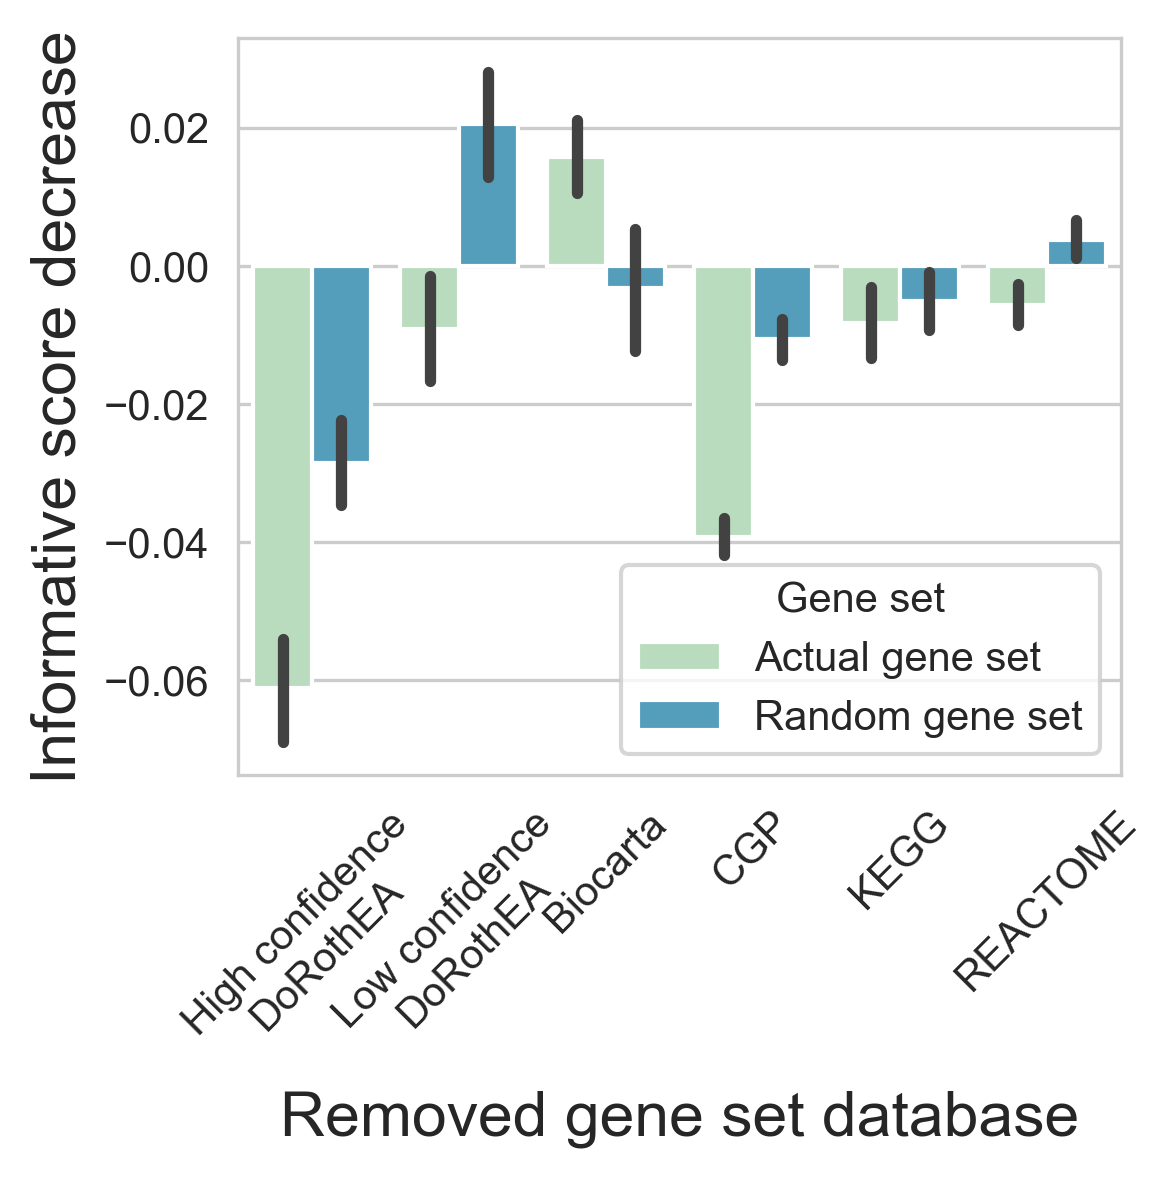

In [16]:
delta = infromative_score_decrease(bname='gdsc', atype='_abs')
delta.index = range(len(delta.index))
plt.savefig('../figures/raw/SFig7E.pdf')
delta.to_csv('../results/benchmark/gdsc_abs_remove.csv')

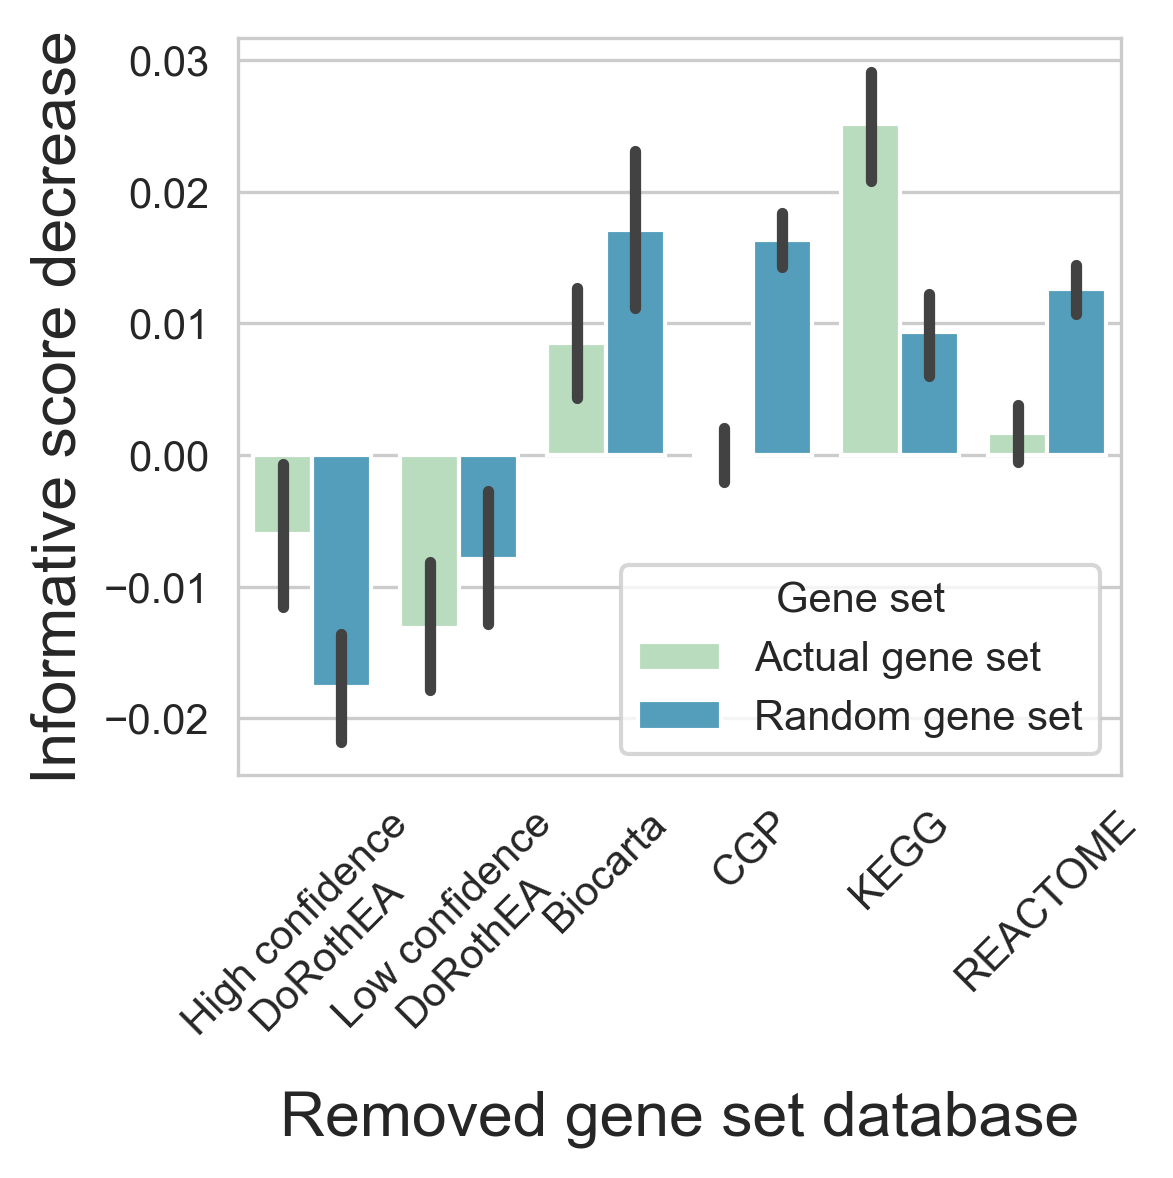

In [17]:
delta = infromative_score_decrease(bname='gdsc', atype='')
delta.index = range(len(delta.index))
plt.savefig('../figures/raw/SFig7F.pdf')
delta.to_csv('../results/benchmark/gdsc_remove.csv')

In [3]:
call(['Rscript','../code/removed_statistics.R'])

0

In [4]:
results = pd.read_csv('../results/benchmark/remove_stats.csv', sep=',', header=0, index_col=0)

In [5]:
results

,anova_d,anova_r,anova_s,pcd,pbio,pcgp,pkegg,preac,cd,bio,cgp,kegg,reac
progeny_abs_remove,8.740000e-186,2.030000e-210,9.630000e-01,0.000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.22900,0.1800,0.11900,0.1690,0.1780
progeny_remove,3.070000e-50,2.130000e-253,2.030000e-02,0.000,0.0000,1.050000e-12,2.890000e-15,1.110000e-15,0.13700,0.1490,0.06030,0.0730,0.0684
gdsc_abs_remove,4.460000e-134,1.080000e-36,2.280000e-18,0.000,0.0000,7.940000e-07,0.000000e+00,0.000000e+00,0.05970,0.0911,0.02010,0.0561,0.0587
gdsc_remove,1.620000e-62,2.490000e-11,1.410000e-03,0.268,0.0137,1.730000e-01,0.000000e+00,1.070000e-01,-0.00893,0.0112,0.00632,0.0303,0.0069
